In [1]:
import numpy as np
import re
import pandas as pd
import os
import cv2 as cv
from glob import glob
from tqdm.auto import tqdm
import spectral as sp
import tensorflow as tf
import keras
import keras.backend as K
from keras import activations
from keras.initializers import RandomNormal
from keras.layers import Dense, Activation, LeakyReLU, ReLU, BatchNormalization, Input, concatenate, ActivityRegularization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Conv3D, Conv3DTranspose, RNN, LSTM, Conv1D, Dropout
from keras.layers.experimental.preprocessing import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, Resizing
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scipy as scp
%matplotlib widget

ModuleNotFoundError: No module named 'cv2'

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

In [3]:
def preprocess12(x):
    return x/4095.0

def deprocess12(x):
    return np.uint16(((x+1.0)/2.0)*4095.0)

def preprocess8(x):
    return 2.0*(x/255.0)-1.0

def deprocess(x):
    return np.float32((x+1.0)/2.0)

def preprocess(x):
    ret, mask = cv.threshold(x[:, :, [14]], 0.1, 1, cv.THRESH_BINARY)
    
    x = x * mask.reshape((650, 800, 1,))
        
    return 2.0*x-1.0

# def load_image(file, directory='F:/LimonesDeep_5_3_21', nir_bands=31):
#     # crop
#     rows = (200, 850)
#     cols = (300, 1100)
    
#     avis = sp.io.envi.open(directory+'/Muestras/'+file+'_VIS.hdr')
#     anir  = sp.io.envi.open(directory+'/Muestras/'+file+'_NIR.hdr')
#     rbvis = sp.io.envi.open(directory+'/Referencias/'+file.split('_')[0]+'_REFB_VIS.hdr')
#     rbnir = sp.io.envi.open(directory+'/Referencias/'+file.split('_')[0]+'_REFB_NIR.hdr')
#     rnvis = sp.io.envi.open(directory+'/Referencias/'+file.split('_')[0]+'_REFN_VIS.hdr')
#     rnnir = sp.io.envi.open(directory+'/Referencias/'+file.split('_')[0]+'_REFN_NIR.hdr')
    
#     avis = avis.read_subregion(rows, cols)
#     anir = anir.read_subregion(rows, cols, bands=range(8, nir_bands))
#     rbvis = rbvis.read_subregion(rows, cols)
#     rbnir = rbnir.read_subregion(rows, cols, bands=range(8, nir_bands))
#     rnvis = rnvis.read_subregion(rows, cols)
#     rnnir = rnnir.read_subregion(rows, cols, bands=range(8, nir_bands))

#     avis = 4095*((avis - rnvis)/(rbvis - rnvis))
#     anir = 4095*((anir - rnnir)/(rbnir - rnnir))
#     img = np.concatenate((avis, anir), axis=-1)
    
#     # resize?
#     return img

def load_image(file, normal = True):
    # crop
    # rows = (200, 850)
    # cols = (300, 1100)
    
    mango = sp.io.envi.open(file)
    
    if normal:
        mango = mango.read_bands(np.concatenate([range(28), range(36, 62)]))
    else:
        mango = mango.read_bands(np.concatenate([range(3, 31), range(39, 65)]))
    
    # resize?
    return mango

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

def show_losses(train, evaluation, names=[], file="train_eval_losses.jpg"):
    train = np.array(train)
    evaluation = np.array(evaluation)
    x = np.ones(len(train))
    for i in range(len(train)): 
      x[i] = i+1
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(x, train)
    plt.grid()
    #plt.yscale('log')
    plt.title("Training Losses")
    plt.legend(names)
    plt.subplot(1,2,2)
    plt.plot(x, evaluation)
    plt.grid()
    #plt.yscale('log')
    plt.title("Evaluation Losses")
    plt.legend(names)
    plt.savefig(file)
    plt.show()

def show_images(generated_images, cols=10, file='image.jpg'):
    n_images = len(generated_images)
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig(file)
    plt.show()

In [4]:
# Lectura de archivos
files_control = []
files_inoculados = []
for i in os.listdir('D:/MANGOS/e12/cal'):
    for j in os.listdir('D:/MANGOS/e12/cal/' + i + '/knc'):
        if re.findall("red_cal.hdr\Z", j): files_control.append('D:/MANGOS/e12/cal/' + i + '/knc/' + j)
    for j in os.listdir('D:/MANGOS/e12/cal/' + i + '/kni'):
        if re.findall("red_cal.hdr\Z", j): files_inoculados.append('D:/MANGOS/e12/cal/' + i + '/kni/' + j)

for i in os.listdir('D:/MANGOS/e13/cal'):
    for j in os.listdir('D:/MANGOS/e13/cal/' + i + '/ktc'):
        if re.findall("red_cal.hdr\Z", j): files_control.append('D:/MANGOS/e13/cal/' + i + '/ktc/' + j)
    for j in os.listdir('D:/MANGOS/e13/cal/' + i + '/kti'):
        if re.findall("red_cal.hdr\Z", j): files_inoculados.append('D:/MANGOS/e13/cal/' + i + '/kti/' + j)

files_control = np.array(files_control)
files_inoculados = np.array(files_inoculados)

print(files_control.shape)
print(files_inoculados.shape)

# Eliminamos los mangos mal corregistrados
# control 4 día 6 -> files_control[54]
# inoculado 4 día 4 -> files_inoculados[193]
# inoculado 1 día 7 -> files_inoculados[310]

files_control = np.delete(files_control, 54)
files_inoculados = np.delete(files_inoculados, [193, 310])

print(files_control.shape)
print(files_inoculados.shape)

control_train, control_test = train_test_split(files_control, test_size=40, random_state=42)
inoculados_train, inoculados_test = train_test_split(files_inoculados, test_size=140, random_state=42)

print(control_train.shape, control_test.shape)
print(inoculados_train.shape, inoculados_test.shape)

(180,)
(854,)
(179,)
(852,)
(139,) (40,)
(712,) (140,)


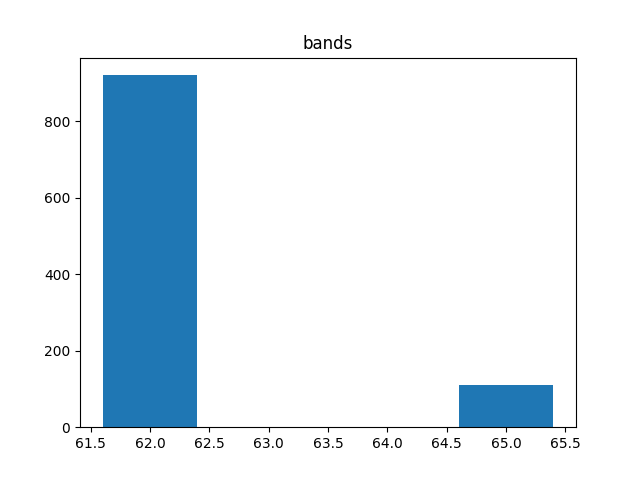

In [5]:
plt.close('all')

channels = []
aux = []
for file in np.concatenate([files_control, files_inoculados]):
    channels.append(len(sp.io.envi.open(file).bands.centers))

for i in np.unique(channels):
    aux.append(sum(channels == i))

plt.bar(np.unique(channels), aux)
plt.title('bands')
plt.show()

In [6]:
# imágenes con 65 bandas en vez de 62
files_65 = np.concatenate([files_control, files_inoculados])[np.where(np.array(channels) == 65)[0]]
files_65.shape

(110,)

# Modelo red convolucional propuesta

In [7]:
# data augmentation simple con las capas disponibles en keras

# data augmentation control
resize = Resizing(600, 600)

input = Input((600, 600, 54))
layer = RandomRotation(1, fill_mode='constant')(input)
layer = RandomZoom(1, fill_mode='constant')(layer)
layer = RandomFlip()(layer)
layer = RandomTranslation(0.5, 0.5)(layer)
output = RandomContrast(0.5)(layer)

control_augmentate = Model(input, output)

# data augmentation inoculados
input = Input((600, 600, 54))
layer = RandomRotation(0.5, fill_mode='constant')(input)
layer = RandomZoom(0.2, fill_mode='constant')(layer)
layer = RandomFlip()(layer)
layer = RandomTranslation(0.2, 0.2)(layer)
output = RandomContrast(0.5)(layer)

inoculado_augmentate = Model(input, output)

# el data augmentation de control es diferente al de inoculados por si acaso el proceso es 
# demasiado fuerte y no aparece ninguna zona con hongo en una imagen etiquetada como inoculado

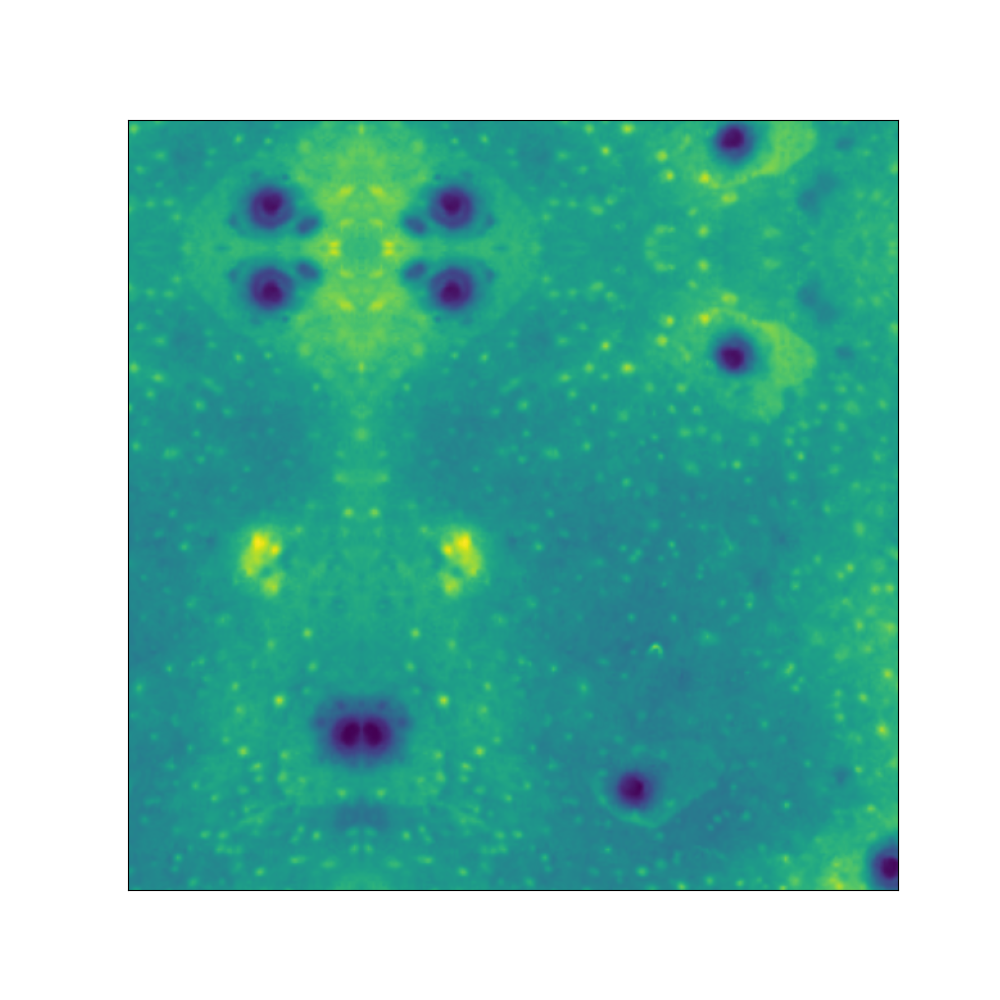

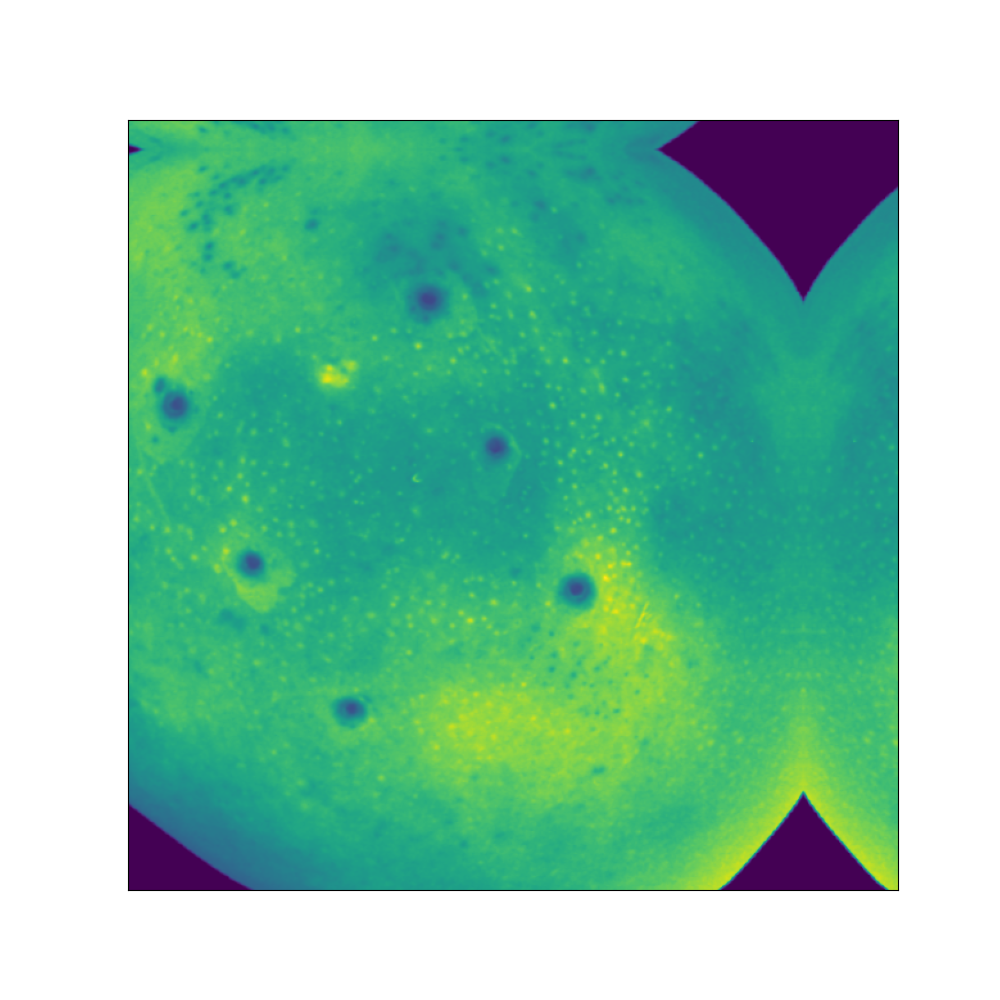

In [8]:
plt.close('all')

img = preprocess12(load_image(files_inoculados[100]))

img = resize(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))

aux = control_augmentate(img)

plt.figure(figsize = (10, 10))
plt.imshow(aux[0, :, :, 0])
plt.xticks([])
plt.yticks([])
plt.show()

aux = inoculado_augmentate(img)

plt.figure(figsize = (10, 10))
plt.imshow(aux[0, :, :, 0])
plt.xticks([])
plt.yticks([])
plt.show()

### Training

In [134]:
learning_rate = 0.01  # /50
beta_1        = 0.8
eps           = 0.0000001
init_std      = 0.2

batch_size  = 5 # 128  # train batch size

# evaluate size:
eval_size   = 5 # 8*16  

In [ ]:
# Modelo v1

input = Input((600, 600, 54))

layer = Conv2D(128, kernel_size=7, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std), 
               input_shape=(600, 600, 54))(input)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(64, kernel_size=5, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(32, kernel_size=5, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(16, kernel_size=5, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(8, kernel_size=3, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)

layer = Flatten()(layer)
layer = Dense(100, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Dense(60, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Dense(40, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Dense(15, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
output = Dense(1, kernel_initializer=RandomNormal(stddev=init_std))(layer)

net = Model(input, output)
net.compile(optimizer=Adam(lr=learning_rate, beta_1=beta_1, epsilon=eps, amsgrad=True), loss=keras.losses.MeanAbsoluteError())

print(net.summary())

In [114]:
# Modelo v2
# Cambio la salida a 2 neuronas y entrenamos con categorical crossentropy

input = Input((600, 600, 54))

layer = Conv2D(128, kernel_size=11, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std), 
               input_shape=(600, 600, 54))(input)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(32, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(16, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(8, kernel_size=3, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)

layer = Flatten()(layer)
layer = Dense(60, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Dense(40, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Dense(15, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
output = Dense(2, kernel_initializer=RandomNormal(stddev=init_std), activation='sigmoid')(layer)

net = Model(input, output)
net.compile(optimizer=Adam(lr=learning_rate, beta_1=beta_1, epsilon=eps, amsgrad=True), loss=keras.losses.CategoricalCrossentropy())

print(net.summary())

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 600, 600, 54)]    0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 200, 200, 128)     836480    
_________________________________________________________________
batch_normalization_99 (Batc (None, 200, 200, 128)     512       
_________________________________________________________________
re_lu_99 (ReLU)              (None, 200, 200, 128)     0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 100, 100, 64)      204864    
_________________________________________________________________
batch_normalization_100 (Bat (None, 100, 100, 64)      256       
_________________________________________________________________
re_lu_100 (ReLU)             (None, 100, 100, 64)      0  

In [135]:
# Modelo v3
# elimino capa densa y cambio tamaño filtro cv2 (a ver si me he pasado reduciendo dimensionalidad)

input = Input((600, 600, 54))

layer = Conv2D(128, kernel_size=11, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std), 
               input_shape=(600, 600, 54))(input)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(64, kernel_size=7, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(32, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(16, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(8, kernel_size=3, strides=3, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)

layer = Flatten()(layer)
layer = Dense(100, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Dense(40, kernel_initializer=RandomNormal(stddev=init_std))(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
output = Dense(2, kernel_initializer=RandomNormal(stddev=init_std), activation='sigmoid')(layer)

net = Model(input, output)
net.compile(optimizer=Adam(lr=learning_rate, beta_1=beta_1, epsilon=eps, amsgrad=True), loss=keras.losses.CategoricalCrossentropy())

print(net.summary())

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 600, 600, 54)]    0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 200, 200, 128)     836480    
_________________________________________________________________
batch_normalization_114 (Bat (None, 200, 200, 128)     512       
_________________________________________________________________
re_lu_107 (ReLU)             (None, 200, 200, 128)     0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 100, 100, 64)      401472    
_________________________________________________________________
batch_normalization_115 (Bat (None, 100, 100, 64)      256       
_________________________________________________________________
re_lu_108 (ReLU)             (None, 100, 100, 64)      0  

### Bucle entrenamiento

In [136]:
train_loss = []
eval_loss = []
best = 1000

In [ ]:
plt.close('all')
%matplotlib inline

epochs = 50

for e in range(epochs):
    # train
    aux = []
    
    for i in tqdm(range(len(control_train))):

        batch = control_train[i]
        batch = (resize([preprocess12(load_image(batch, ~np.any(batch in files_65)))]) + 1.0) / 2.0
        
        batch_aug = batch
        for _ in range(9):
            batch_aug = np.concatenate([batch_aug, control_augmentate(batch)])
            
        loss = net.train_on_batch(batch_aug, np.array([np.ones(10), np.zeros(10)]).transpose())
        aux.append(loss)
    
    for i in tqdm(range(len(inoculados_train)//batch_size)):

        batch = inoculados_train[i*batch_size:(i+1)*batch_size]
        batch = (np.array([resize([preprocess12(load_image(file, ~np.any(file in files_65)))]) for file in batch]).reshape(batch_size, 600, 600, 54) + 1.0) / 2.0
        
        batch_aug = np.concatenate([batch, inoculado_augmentate(batch)])
        
        loss = net.train_on_batch(batch_aug, np.array([np.zeros(10), np.ones(10)]).transpose())
        aux.append(loss)
    
    train_loss.append(np.mean(aux))
    
    # evaluate
    aux_eval = []
    
    for i in tqdm(range(len(control_test)//eval_size)):
        
        batch = control_test[i*eval_size:(i+1)*eval_size]
        batch = (np.array([resize([preprocess12(load_image(file, ~np.any(file in files_65)))]) for file in batch]).reshape(eval_size, 600, 600, 54) + 1.0) / 2.0
        
        loss  = net.test_on_batch(batch, np.array([np.ones(eval_size), np.zeros(eval_size)]).transpose())
        aux_eval.append(loss)
        
    for i in tqdm(range(len(inoculados_test)//eval_size)):
        
        batch = inoculados_test[i*eval_size:(i+1)*eval_size]
        batch = (np.array([resize([preprocess12(load_image(file, ~np.any(file in files_65)))]) for file in batch]).reshape(eval_size, 600, 600, 54) + 1.0) / 2.0
        
        loss  = net.test_on_batch(batch, np.array([np.zeros(eval_size), np.ones(eval_size)]).transpose())
        aux_eval.append(loss)
    
    eval_loss.append(np.mean(aux_eval))
    
    if eval_loss[-1] < best:
        net.save_weights("best_model_v3.h5")
        best = eval_loss[-1]
    
    print("Epoch: {:>3}/{} | Loss training: {:>6.8f} Loss evaluation: {:>6.8f}".format(e+1, epochs, train_loss[-1], eval_loss[-1]))

    show_losses(train_loss, eval_loss, file='losses_mangos_v3.pdf')
    net.save_weights("last_model_v3.h5")

In [122]:
net.load_weights("best_model_v3.h5")

In [115]:
net.load_weights("last_model_v3.h5")

### Test

In [140]:
plt.close('all')

y    = np.array([[-1, -1]])
pred = np.array([[-1, -1]])

for i in tqdm(range(len(control_test)//eval_size)):

    batch = control_test[i*eval_size:(i+1)*eval_size]
    
    batch = (np.array([resize([preprocess12(load_image(file, ~np.any(file in files_65)))]) for file in batch]).reshape(eval_size, 600, 600, 54) + 1.0) / 2.0

    pred  = np.concatenate([pred, net.predict(batch)])
    y     = np.concatenate([y, np.array([np.ones(eval_size), np.zeros(eval_size)]).transpose()])

for i in tqdm(range(len(inoculados_test)//eval_size)):

    batch = inoculados_test[i*eval_size:(i+1)*eval_size]

    batch = (np.array([resize([preprocess12(load_image(file, ~np.any(file in files_65)))]) for file in batch]).reshape(eval_size, 600, 600, 54) + 1.0) / 2.0

    pred  = np.concatenate([pred, net.predict(batch)])
    y     = np.concatenate([y, np.array([np.zeros(eval_size), np.ones(eval_size)]).transpose()])

y    = y[1:, :]
pred = pred[1:, :]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

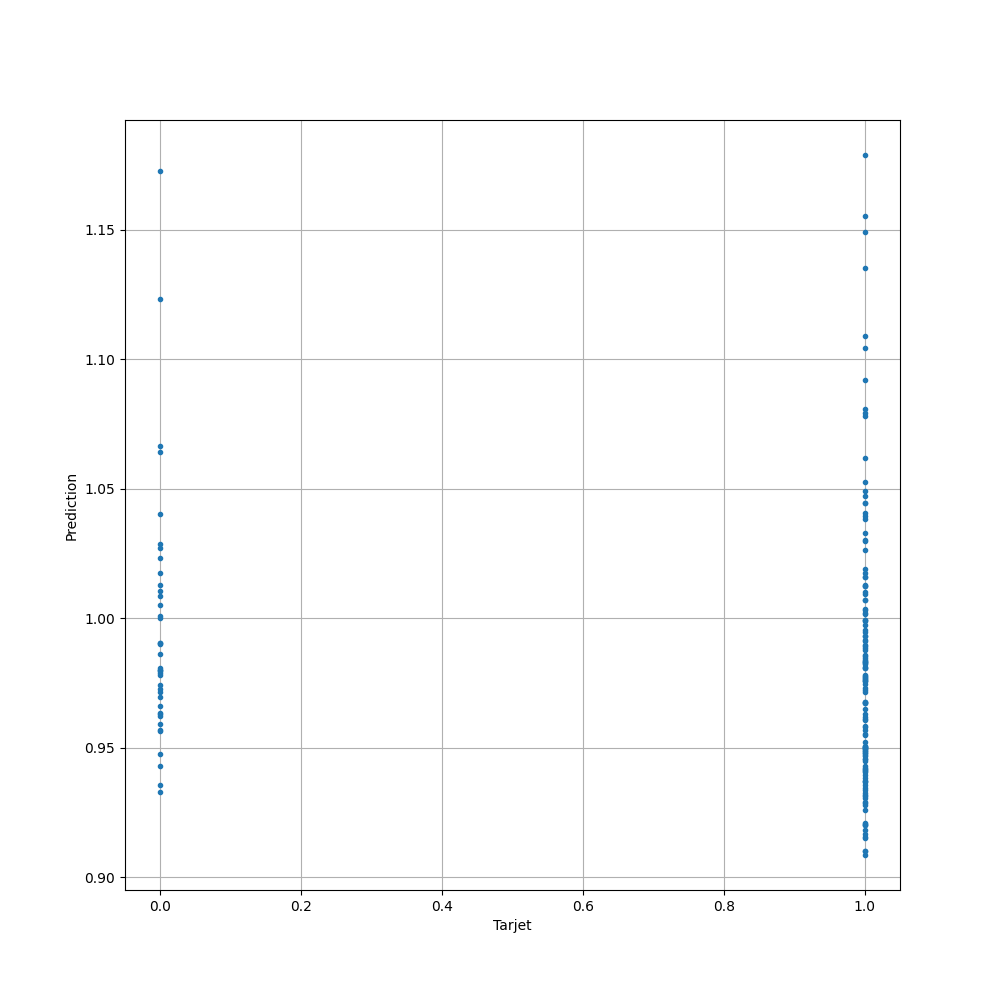

In [53]:
plt.close('all')

plt.figure(figsize = (10, 10))
plt.plot(y, pred, '.')
plt.xlabel('Tarjet')
plt.ylabel('Prediction')
plt.grid()
plt.show()

In [ ]:
plt.close('all')

n_classes = 2
y_test = y
y_score = pred
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

# Pruebas algoritmo de segmentación

In [ ]:
plt.close('all')

img = load_image(files_control[178])

plt.figure(figsize = (20, 30))
for i in range(54):
    plt.subplot(9, 6, i+1)
    plt.imshow(img[:, :, i])
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')

img = preprocess12(load_image(files_inoculados[850]))

plt.figure(figsize = (20, 30))
for i in range(54):
    plt.subplot(9, 6, i+1)
    plt.imshow(img[:, :, i])
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')

plt.figure(figsize = (20, 40))
aux = []
for i in range(54):
    plt.subplot(18, 6, i+1+6*(i//6))
    plt.imshow(img[:, :, i])
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(18, 6, i+7+6*(i//6))
    a = plt.hist(img[:, :, i].ravel(), bins = 50)
    aux.append(scp.stats.skew(img[img[:, :, i] != 0.0, i].ravel()))
    plt.title(aux[-1])
plt.tight_layout()
plt.show()

#### La intención de los histogramas y el calculo de los momentos de tercer orden (skewness) es intentar encontrar algún tipo de parámetro con el que identificar la mejor banda con la que realizar la segmentación

In [ ]:
plt.close('all')
from matplotlib import cm
from scipy.signal import savgol_filter

n = np.argmin(aux)
window = 301
p = 1
deriv = 0
delta = 30

ret, mask = cv.threshold(img[:, :, n], 0, 1, cv.THRESH_BINARY)
ret, mask_inv = cv.threshold(img[:, :, n], 0, 1, cv.THRESH_BINARY_INV)

X, Y = np.meshgrid(range(mask.shape[1]), range(mask.shape[0]))

fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={"projection": "3d"})
ax.plot_surface(Y, X, img[:, :, n], cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()
# aplico filtro de savgol para intentar obtener el factor de forma a partir de la imagen eliminando el "ruido" por los productos de luz difusa
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={"projection": "3d"})
interp = scp.signal.savgol_filter(img[:, :, n] + mask_inv * np.mean(img[:, :, n]), window, p, deriv, delta, axis = 0, mode='nearest')
interp = scp.signal.savgol_filter(interp, window, p, deriv, delta, axis = 1, mode='nearest')
ax.plot_surface(Y, X, interp, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()
# plot del factor de corrección
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={"projection": "3d"})
ax.plot_surface(Y, X, (np.max(interp) - interp) * mask, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()
# imagen corregida a partir de la cual se segmentan los píxeles
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={"projection": "3d"})
ax.plot_surface(Y, X, img[:, :, n] + (np.max(interp) - interp) * mask, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [ ]:
plt.close('all')

ret, mask = cv.threshold(img[:, :, n], 0, 1, cv.THRESH_BINARY)
ret, mask_inv = cv.threshold(img[:, :, n], 0, 1, cv.THRESH_BINARY_INV)

interp = scp.signal.savgol_filter(img[:, :, n] + mask_inv * np.mean(img[:, :, n]), window, p, deriv, delta, axis = 0, mode='nearest')
interp = scp.signal.savgol_filter(interp, window, p, deriv, delta, axis = 1, mode='nearest')

correction = (np.max(interp) - interp) * mask
ret, mask = cv.threshold(img[:, :, n] + correction, np.mean(img[:, :, n]), 1, cv.THRESH_BINARY_INV)
# np.quantile(img[img[:, :, n] != 0, n], 0.5)

plt.figure(figsize = (20, 30))
for i in range(54):
    plt.subplot(9, 6, i+1)
    plt.imshow(img[:, :, i] * mask)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

#### Prueba para varias imágenes

In [ ]:
plt.close('all')

for j in range(0, 180, 5):
    img = preprocess12(load_image(files_control[j]))
    
    plt.figure(figsize = (20, 40))
    aux = []
    for i in range(54):
        plt.subplot(18, 6, i+1+6*(i//6))
        plt.imshow(img[:, :, i])
        plt.title(i)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(18, 6, i+7+6*(i//6))
        a = plt.hist(img[:, :, i].ravel(), bins = 50)
        aux.append(scp.stats.skew(img[img[:, :, i] != 0.0, i].ravel()))
        plt.title(aux[-1])
    plt.tight_layout()
    plt.show()
    
    n = np.argmin(aux)
    
    ret, mask = cv.threshold(img[:, :, n], 0, 1, cv.THRESH_BINARY)
    ret, mask_inv = cv.threshold(img[:, :, n], 0, 1, cv.THRESH_BINARY_INV)
    
    interp = scp.signal.savgol_filter(img[:, :, n] + mask_inv * np.mean(img[:, :, n]), window, p, axis = 0, mode='nearest')
    interp = scp.signal.savgol_filter(interp, window, p, axis = 1, mode='nearest')
    
    correction = (np.max(interp) - interp) * mask
    ret, mask = cv.threshold(img[:, :, n] + correction, np.mean(img[:, :, n]), 1, cv.THRESH_BINARY_INV)

    plt.figure(figsize = (20, 30))
    for i in range(54):
        aux = img[:, :, i] * mask
        plt.subplot(9, 6, i+1)
        plt.imshow(aux)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()